# 新冠疫情对于2020年第一季度供水量影响

 除夕前两周进入春运，选取除夕前一月到次年三月为比较时间段2019年12月24日到2020年3月31日一共98天， 同理选取2019年1月4日到2019年4月12日

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import datetime as dt

startday = dt.datetime(2019,11,24)
endday = dt.datetime(2020,3,31)
endday-startday


datetime.timedelta(days=128)

In [2]:
startday_lastyear = dt.datetime(2018,12,5)
endday_lastyear = startday_lastyear + dt.timedelta(days=128)
print(endday_lastyear)

2019-04-12 00:00:00


读取日供水总量，并选取上面两个时间段，分别做曲线

Text(0.5, 1.0, '日供水总量')

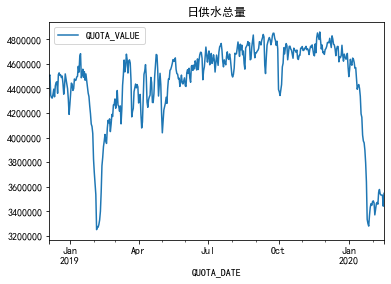

In [13]:
sup_water = pd.read_excel(r'./自来水数据/春节期间供水总量.xlsx')
sup_water = sup_water[['QUOTA_DATE','QUOTA_VALUE']].set_index('QUOTA_DATE').sort_index()
sup_water.plot()
plt.title('日供水总量')

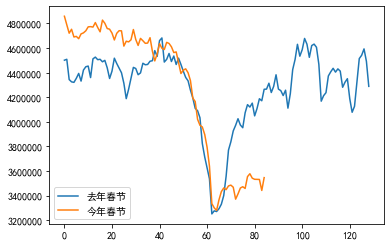

In [17]:
plt.plot(sup_water['2018-12-5':'2019-4-12'].values)
plt.plot(sup_water['2019-11-24':].values)
plt.legend(['去年春节','今年春节'])

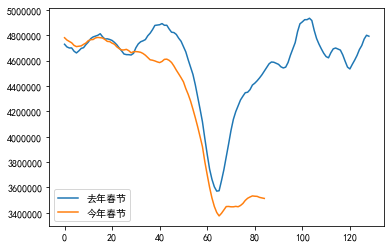

In [15]:
plt.plot(sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.07)
plt.plot(sup_water['2019-11-24':]['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values)
plt.legend(['去年春节','今年春节'])

1月23日武汉封城作为，疫情发生明显影响开始点，对1月23日前数据乘以系数，模拟今年供水水平。

对2月18到3月31日供水总量做一个时间序列预测，时间序列按照疫情影响结束2月29日为时间点。采用做一个短期时间序列预测。

In [25]:
import numpy as np
np.set_printoptions(suppress=True) 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [42]:
# 移动平均图
def draw_trend(timeSeries, size):
    plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size,min_periods=1,center=True).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = timeSeries.ewm(span=size).mean()
 
    timeSeries.plot(color='blue', label='原曲线',alpha=0.7)
    rol_mean.plot(color='red', label='移动平均',alpha=0.7)
    rol_weighted_mean.plot(color='black', label='指数加权移动平均',alpha=0.7)
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show() 
'''
　　ADF检验，p值小于0.05，则为稳定数据
'''
def testStationarity(ts):
    dftest = sm.tsa.adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput 
# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=20):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = f.add_subplot(212)
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)
    plt.show()

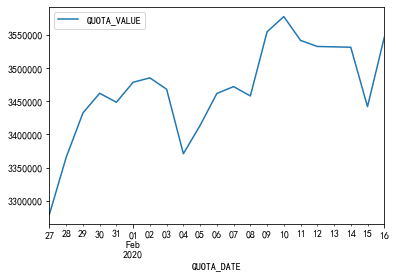

In [40]:
#画时间线
sup_water['2020-1-27':].plot()

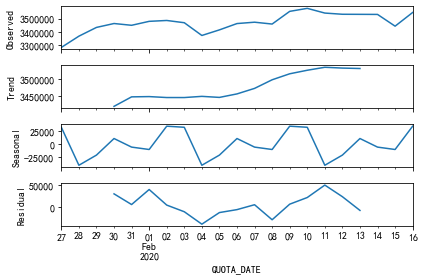

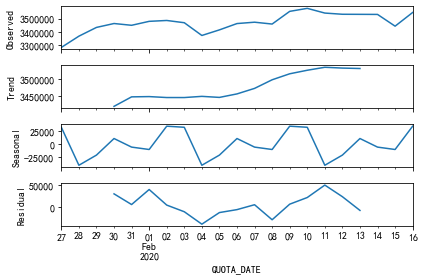

In [53]:
#历史数据时间序列因素分解图
sm.tsa.seasonal_decompose(sup_water['2020-1-27':]).plot()

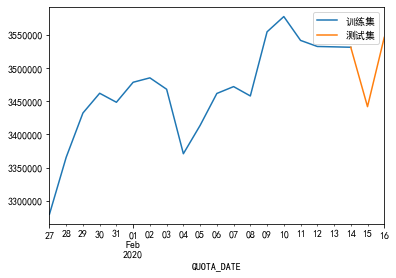

In [105]:
#划分数据  

train = sup_water['2020-1-27':'2020-2-14']
test = sup_water['2020-2-14':]
train['QUOTA_VALUE'].plot(label='训练集')
test['QUOTA_VALUE'].plot(label='测试集')
plt.legend(loc='best')
focastQuota = 'QUOTA_VALUE'

指数平滑模型参数
model = ExponentialSmoothing(train, seasonal='additive', seasonal_periods = seasonal_periods).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])
trend ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of trend component.
seasonal ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of seasonal component.

 fit(self, smoothing_level=None, smoothing_slope=None, smoothing_seasonal=None,
      damping_slope=None, optimized=True, use_boxcox=False, remove_bias=False,
      use_basinhopping=False)
 若需详细了解 - 建议看源码
 https://www.statsmodels.org/stable/_modules/statsmodels/tsa/holtwinters.html#ExponentialSmoothing
smoothing_level=None     ## alpha
smoothing_slope=None     ## beta 
smoothing_seasonal=None  ## gamma 
damping_slope=None       ## phi value of the damped method
optimized=True           ## hould the values that have not been set above be optimized automatically?
use_boxcox=False         ## {True, False, 'log', float} log->apply log; float->lambda equal to float.
remove_bias=False        ## 
use_basinhopping=False   ## Should the opptimser try harder using basinhopping to find optimal values?ym

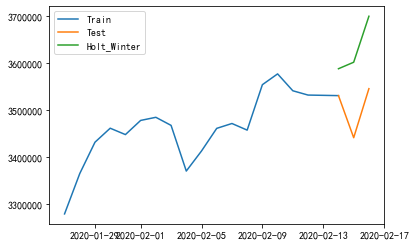

均方根误差RMSE：132631.870；
R方：-728.20%。


array([3588514.80848839, 3602346.01719819, 3700159.0079513 ,
       3684122.49460335, 3640859.05603425, 3629343.98083456,
       3562357.16562924, 3622887.57573901, 3664067.81256452,
       3677899.02127432])

In [209]:
y_hat_avg = test.copy()
fit = sm.tsa.ExponentialSmoothing(np.array(train[focastQuota]),seasonal_periods=8,trend='add',seasonal='add').fit(smoothing_level=0.8,
                                                                                                                  smoothing_slope=0.1,
                                                                                                                 smoothing_seasonal=0.8)
y_hat_avg['Holt_Winter'] = fit.forecast(len(test))
plt.figure()
plt.plot(train[focastQuota], label='Train')
plt.plot(test[focastQuota], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()
rmse = np.sqrt(mean_squared_error(test[focastQuota], y_hat_avg['Holt_Winter']))
R2 = r2_score(test[focastQuota], y_hat_avg['Holt_Winter'])
print("均方根误差RMSE：{:.3f}；\nR方：{:.2%}。".format(rmse,R2))
fit.forecast(10)

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


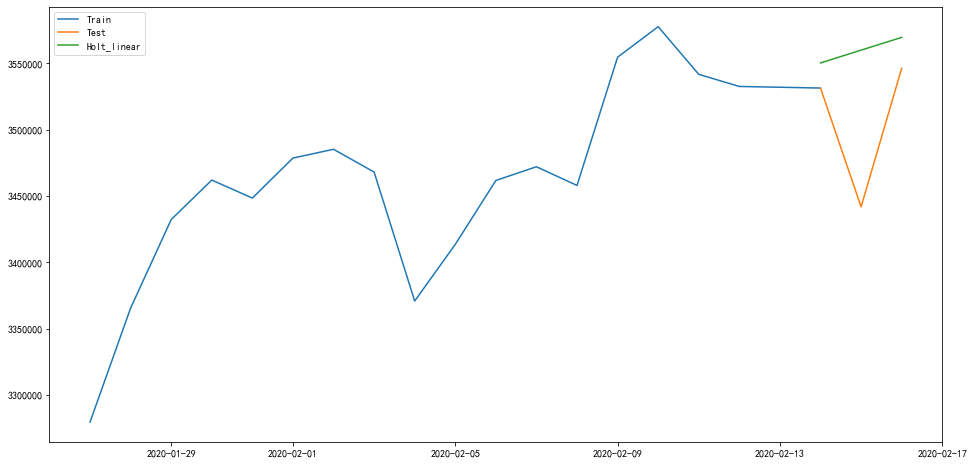

70339.50540055479


array([3550240.22598226, 3559862.81801387])

In [210]:
#霍尔特(Holt)线性趋势法（等同二次指数平滑） 


y_hat_avg = test.copy() 
fit = sm.tsa.Holt(np.asarray(train[focastQuota])).fit(smoothing_level=0.6,smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit.forecast(len(test)) 
plt.figure(figsize=(16, 8))
plt.plot(train[focastQuota], label='Train')
plt.plot(test[focastQuota], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

rms = np.sqrt(mean_squared_error(test[focastQuota], y_hat_avg['Holt_linear']))
print(rms)
fit.forecast(2) 

In [212]:
sm.tsa.stattools.adfuller(train[focastQuota])


(0.5194453314440272,
 0.9854522905204213,
 7,
 11,
 {'1%': -4.223238279489106,
  '5%': -3.189368925619835,
  '10%': -2.729839421487603},
 256.7806268553149)

In [214]:
#季节性自回归差分移动平均模型SARIMAX
##稳定性检验
testStationarity(train[focastQuota])


Test Statistic                  0.519445
p-value                         0.985452
#Lags Used                      7.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64

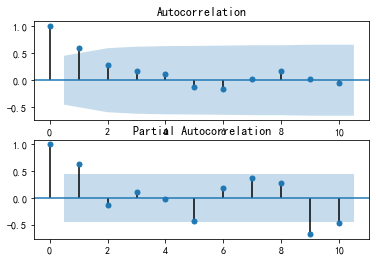

In [223]:
##画自相关图与偏自相关图
draw_acf_pacf(train[focastQuota],10)


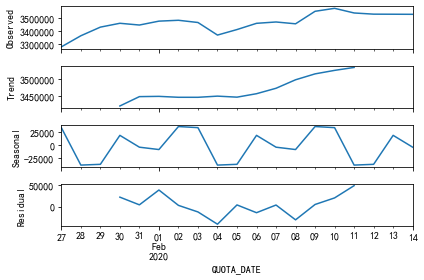

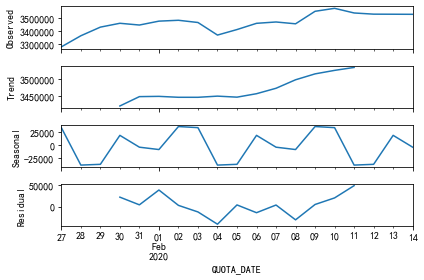

In [224]:
sm.tsa.seasonal_decompose(train[focastQuota]).plot()

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


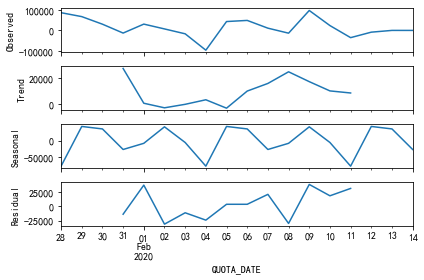

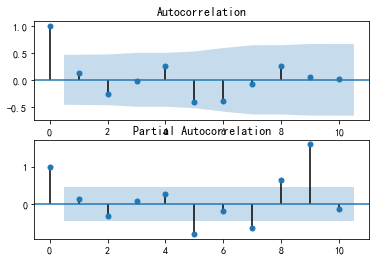

In [225]:
data_diff1 = train[focastQuota].diff(1)
data_diff1.dropna(inplace=True)
testStationarity(data_diff1)
sm.tsa.seasonal_decompose(data_diff1).plot()
draw_acf_pacf(data_diff1,10)

In [229]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,10)
d = [1]
q = range(0,2)
# Generate all different combinations of p, q and q triplets
import itertools
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 8) for x in list(itertools.product(p, d, q))]

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
df1 = pd.DataFrame(columns=('param', ' param_seasonal', 'rmse'))
i = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            fit = sm.tsa.SARIMAX(train[focastQuota],order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit()

            y_hat_avg['SARIMA'] = fit.predict(start="2020-2-14", end="2020-2-16", dynamic=True)
            rmse = np.sqrt(mean_squared_error(test[focastQuota], y_hat_avg['SARIMA']))
            df1.loc[i] = [param,param_seasonal,rmse]
            i+=1
#            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))        
            
        except:
            continue
df1.sort_values(['rmse'])

,param,param_seasonal,rmse
3,"(0, 1, 1)","(1, 1, 0, 8)",4.971680e+04
5,"(1, 1, 0)","(1, 1, 0, 8)",5.086549e+04
7,"(1, 1, 1)","(1, 1, 0, 8)",5.156676e+04
1,"(0, 1, 0)","(1, 1, 0, 8)",6.101886e+04
34,"(8, 1, 1)","(0, 1, 0, 8)",6.560419e+04
32,"(8, 1, 0)","(0, 1, 0, 8)",7.092409e+04
35,"(8, 1, 1)","(1, 1, 0, 8)",8.065218e+04
33,"(8, 1, 0)","(1, 1, 0, 8)",8.708331e+04
8,"(2, 1, 0)","(0, 1, 0, 8)",8.940186e+04
11,"(2, 1, 1)","(1, 1, 0, 8)",9.004732e+04


In [232]:
y_hat= test.copy()
fit1 = sm.tsa.SARIMAX(train[focastQuota], order=(0, 1, 1), seasonal_order=(1, 1, 0,8),
                      enforce_stationarity=False,enforce_invertibility=False).fit()
y_hat_avg['SARIMA'] = fit1.predict(start='2020-2-17', end=test.index[-1].strftime("2020-2-19"), dynamic=True)

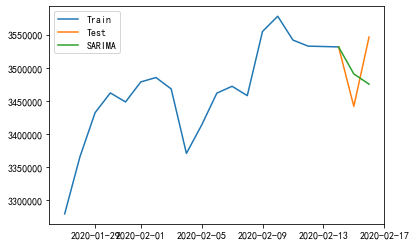

49716.80034270157


In [234]:
plt.plot(train[focastQuota], label='Train')
plt.plot(test[focastQuota], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms = np.sqrt(mean_squared_error(test[focastQuota], y_hat_avg['SARIMA']))
print(rms)

In [238]:
fit1.predict(start='2020-2-17', end="2020-2-29", dynamic=True)

2020-02-17    3.746531e+06
2020-02-18    3.812393e+06
2020-02-19    3.727332e+06
2020-02-20    3.949320e+06
2020-02-21    3.835190e+06
2020-02-22    3.706494e+06
2020-02-23    3.531861e+06
2020-02-24    3.512833e+06
2020-02-25    4.243015e+06
2020-02-26    4.421530e+06
2020-02-27    4.207348e+06
2020-02-28    5.036424e+06
2020-02-29    4.624024e+06
Freq: D, dtype: float64